Вариант: Экономика стран

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, roc_auc_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, confusion_matrix
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import featuretools as ft
from sklearn.metrics import accuracy_score, classification_report

# Функция для применения oversampling
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Функция для применения undersampling
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    """
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    """

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test


df = pd.read_csv("../data/Economic.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stock index          369 non-null    object 
 1   country              369 non-null    object 
 2   year                 369 non-null    float64
 3   index price          317 non-null    float64
 4   log_indexprice       369 non-null    float64
 5   inflationrate        326 non-null    float64
 6   oil prices           369 non-null    float64
 7   exchange_rate        367 non-null    float64
 8   gdppercent           350 non-null    float64
 9   percapitaincome      368 non-null    float64
 10  unemploymentrate     348 non-null    float64
 11  manufacturingoutput  278 non-null    float64
 12  tradebalance         365 non-null    float64
 13  USTreasury           369 non-null    float64
dtypes: float64(12), object(2)
memory usage: 40.5+ KB


Определение бизнес-целей

Задача регрессии:
Предсказать цену индекса (index price) на основе других факторов, таких как инфляция, цены на нефть, обменный курс, ВВП, доход на душу населения, уровень безработицы.

Задача классификации:
Классификация по странам, на основе цены индекса, показателей ВВП, инфляции, безработицы, цены на нефть. Это поможет определить, к какой категории относится страна и какие меры могут быть предприняты для ее развития.

Дополнение данных

In [3]:
data = df.copy()
data_cleaned = df.dropna(subset=['index price', 'inflationrate', 'exchange_rate', 'gdppercent', 'percapitaincome', 'unemploymentrate'])

print(f"Исходный размер датасета: {df.shape[0]}")
print(f"Очищенный размер датасета: {data_cleaned.shape[0]}")

data1 = pd.get_dummies(data_cleaned, columns=['country'], drop_first=True)

Исходный размер датасета: 369
Очищенный размер датасета: 262


Определение достижимого уровня

In [4]:
print(data1.columns)
print(data1.isnull().sum())

Index(['stock index', 'year', 'index price', 'log_indexprice', 'inflationrate',
       'oil prices', 'exchange_rate', 'gdppercent', 'percapitaincome',
       'unemploymentrate', 'manufacturingoutput', 'tradebalance', 'USTreasury',
       'country_France', 'country_Germany', 'country_Hong Kong',
       'country_India', 'country_Japan', 'country_Spain',
       'country_United Kingdom', 'country_United States of America'],
      dtype='object')
stock index                          0
year                                 0
index price                          0
log_indexprice                       0
inflationrate                        0
oil prices                           0
exchange_rate                        0
gdppercent                           0
percapitaincome                      0
unemploymentrate                     0
manufacturingoutput                 41
tradebalance                         2
USTreasury                           0
country_France                       0
country_

In [6]:
X_reg = data1.drop(['stock index', 'year', 'index price', 'log_indexprice', 'manufacturingoutput', 'tradebalance', 'USTreasury'], axis=1)
y_reg = data1['index price']

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Выбор моделей для регрессии
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Создание конвейера для регрессии
pipelines_reg = {}
for name, model in models_reg.items():
    pipelines_reg[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Определение сетки гиперпараметров для регрессии
param_grids_reg = {
    'Linear Regression': {},
    'Random Forest Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

# Настройка гиперпараметров для регрессии
best_models_reg = {}
for name, pipeline in pipelines_reg.items():
    grid_search = GridSearchCV(pipeline, param_grids_reg[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_reg, y_train_reg)
    best_models_reg[name] = {
        'pipeline': grid_search.best_estimator_,
        'best_params': grid_search.best_params_
    }
    print(f'Best parameters for {name}: {grid_search.best_params_}')

# Обучение моделей и оценка качества
for model_name in best_models_reg.keys():
    print(f"Model: {model_name}")
    model_pipeline = best_models_reg[model_name]['pipeline']
    model_pipeline.fit(X_train_reg, y_train_reg)

    y_train_predict = model_pipeline.predict(X_train_reg)
    y_test_predict = model_pipeline.predict(X_test_reg)

    best_models_reg[model_name]["preds_train"] = y_train_predict
    best_models_reg[model_name]["preds_test"] = y_test_predict

    best_models_reg[model_name]["MSE_train"] = mean_squared_error(y_train_reg, y_train_predict)
    best_models_reg[model_name]["MSE_test"] = mean_squared_error(y_test_reg, y_test_predict)
    best_models_reg[model_name]["R2_train"] = r2_score(y_train_reg, y_train_predict)
    best_models_reg[model_name]["R2_test"] = r2_score(y_test_reg, y_test_predict)
    best_models_reg[model_name]["MAE_train"] = mean_absolute_error(y_train_reg, y_train_predict)
    best_models_reg[model_name]["MAE_test"] = mean_absolute_error(y_test_reg, y_test_predict)

Best parameters for Linear Regression: {}
Best parameters for Random Forest Regressor: {'model__max_depth': 10, 'model__n_estimators': 300}
Best parameters for Gradient Boosting Regressor: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 300}
Model: Linear Regression
Model: Random Forest Regressor
Model: Gradient Boosting Regressor


In [ ]:
data2 = data_cleaned.drop(['stock index', 'year', 'log_indexprice', 'exchange_rate', 'percapitaincome', 'manufacturingoutput', 'tradebalance', 'USTreasury'], axis=1)
print(data2["country"].unique())
data2.info()
print(data2["gdppercent"].value_counts())

['United States of America' 'United Kingdom' 'India' 'Japan' 'Hong Kong'
 'China' 'Germany' 'France' 'Spain']
<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, 0 to 367
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           262 non-null    object 
 1   index price       262 non-null    float64
 2   inflationrate     262 non-null    float64
 3   oil prices        262 non-null    float64
 4   gdppercent        262 non-null    float64
 5   unemploymentrate  262 non-null    float64
dtypes: float64(5), object(1)
memory usage: 14.3+ KB
gdppercent
 0.02    55
 0.03    39
 0.04    37
 0.01    30
 0.05    20
 0.08    19
 0.07    14
 0.06    12
-0.01    10
 0.09     6
 0.10     4
 0.11     3
-0.02     2
-0.03     2
-0.05     2
 0.12     1
-0.04     1
-0.10     1
-0.06     1
-0.08     1
 0.13     1
 0.14     1
Name: count, dtype: int64


In [ ]:
# Выбор признаков и целевой переменной для классификации
X_class = data2.drop(['country'], axis=1)
y_class = data2['country']
print(X_class.columns)
# Разделение данных
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=20)

# Выбор моделей для классификации
models_class = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000, solver='liblinear'),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}

# Создание конвейера для классификации
pipelines_class = {}
for name, model in models_class.items():
    pipelines_class[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Определение сетки гиперпараметров для классификации

param_grids_class = {
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__solver': ['lbfgs', 'liblinear']
    },
    'Random Forest Classifier': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Classifier': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}
# Убрал определение параметров поскольку уже был предподсчет данных, но вылетела ошибка. Сохранил лучшие параметры
'''
param_grids_class = {
    'Logistic Regression': {
        'model__C': [10],
        'model__solver': ['lbfgs']
    },
    'Random Forest Classifier': {
        'model__n_estimators': [200],
        'model__max_depth': [ 30]
    },
    'Gradient Boosting Classifier': {
        'model__n_estimators': [200],
        'model__learning_rate': [0.1],
        'model__max_depth': [7]
    }
}'''

# Настройка гиперпараметров для классификации
best_models_class = {}
for name, pipeline in pipelines_class.items():
    grid_search = GridSearchCV(pipeline, param_grids_class[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_class, y_train_class)
    best_models_class[name] = {
        'pipeline': grid_search.best_estimator_,
        'best_params': grid_search.best_params_
    }
    print(f'Best parameters for {name}: {grid_search.best_params_}')

# Обучение моделей и оценка качества
for model_name in best_models_class.keys():
    print(f"Model: {model_name}")

    model_pipeline = best_models_class[model_name]['pipeline']
    model_pipeline.fit(X_train_class, y_train_class)

    y_train_predict = model_pipeline.predict(X_train_class)
    y_test_probs = model_pipeline.predict_proba(X_test_class)
    y_test_predict = model_pipeline.predict(X_test_class)

    best_models_class[model_name]['preds_train'] = y_train_predict
    best_models_class[model_name]["probs"] = y_test_probs
    best_models_class[model_name]["preds"] = y_test_predict

    best_models_class[model_name]["Precision_train"] = precision_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["Precision_test"] = precision_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["Recall_train"] = recall_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["Recall_test"] = recall_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["Accuracy_train"] = accuracy_score(y_train_class, y_train_predict)
    best_models_class[model_name]["Accuracy_test"] = accuracy_score(y_test_class, y_test_predict)
    best_models_class[model_name]["ROC_AUC_test"] = roc_auc_score(y_test_class, y_test_probs, multi_class='ovr', average='weighted')
    best_models_class[model_name]["F1_train"] = f1_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["F1_test"] = f1_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["MCC_test"] = matthews_corrcoef(y_test_class, y_test_predict)
    best_models_class[model_name]["Cohen_kappa_test"] = cohen_kappa_score(y_test_class, y_test_predict)
    best_models_class[model_name]["Confusion_matrix"] = confusion_matrix(y_test_class, y_test_predict)

Index(['index price', 'inflationrate', 'oil prices', 'gdppercent',
       'unemploymentrate'],
      dtype='object')
Best parameters for Logistic Regression: {'model__C': 10, 'model__solver': 'lbfgs'}
Best parameters for Random Forest Classifier: {'model__max_depth': None, 'model__n_estimators': 200}
Best parameters for Gradient Boosting Classifier: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 300}
Model: Logistic Regression
Model: Random Forest Classifier
Model: Gradient Boosting Classifier


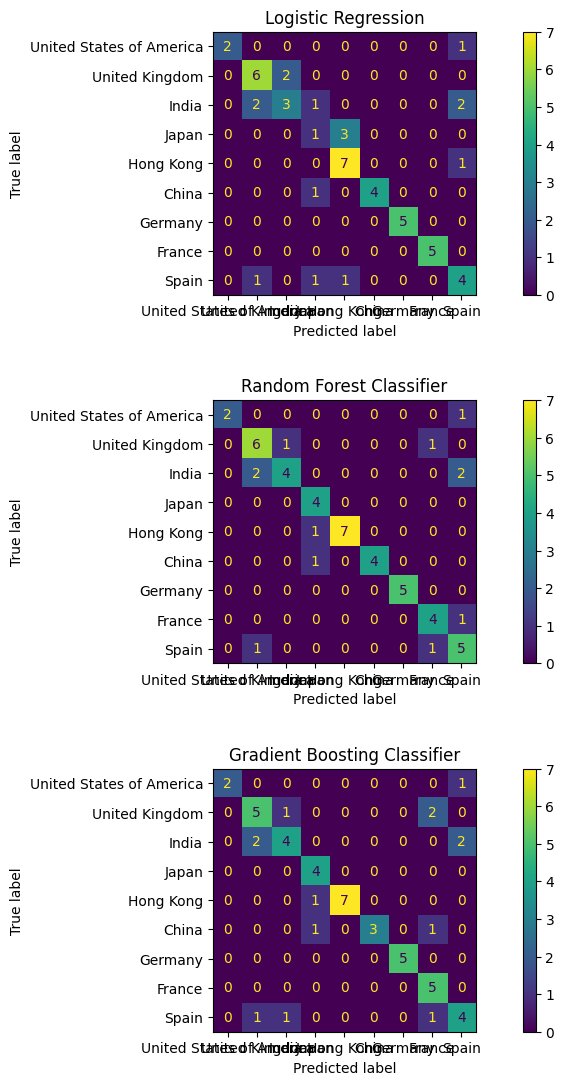

In [ ]:
num_models = len(best_models_class)
fig, ax = plt.subplots(num_models, 1, figsize=(12, 10), sharex=False, sharey=False)
for index, key in enumerate(best_models_class.keys()):
    c_matrix = best_models_class[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=['United States of America', 'United Kingdom', 'India', 'Japan', 'Hong Kong', 'China', 'Germany', 'France', 'Spain']
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

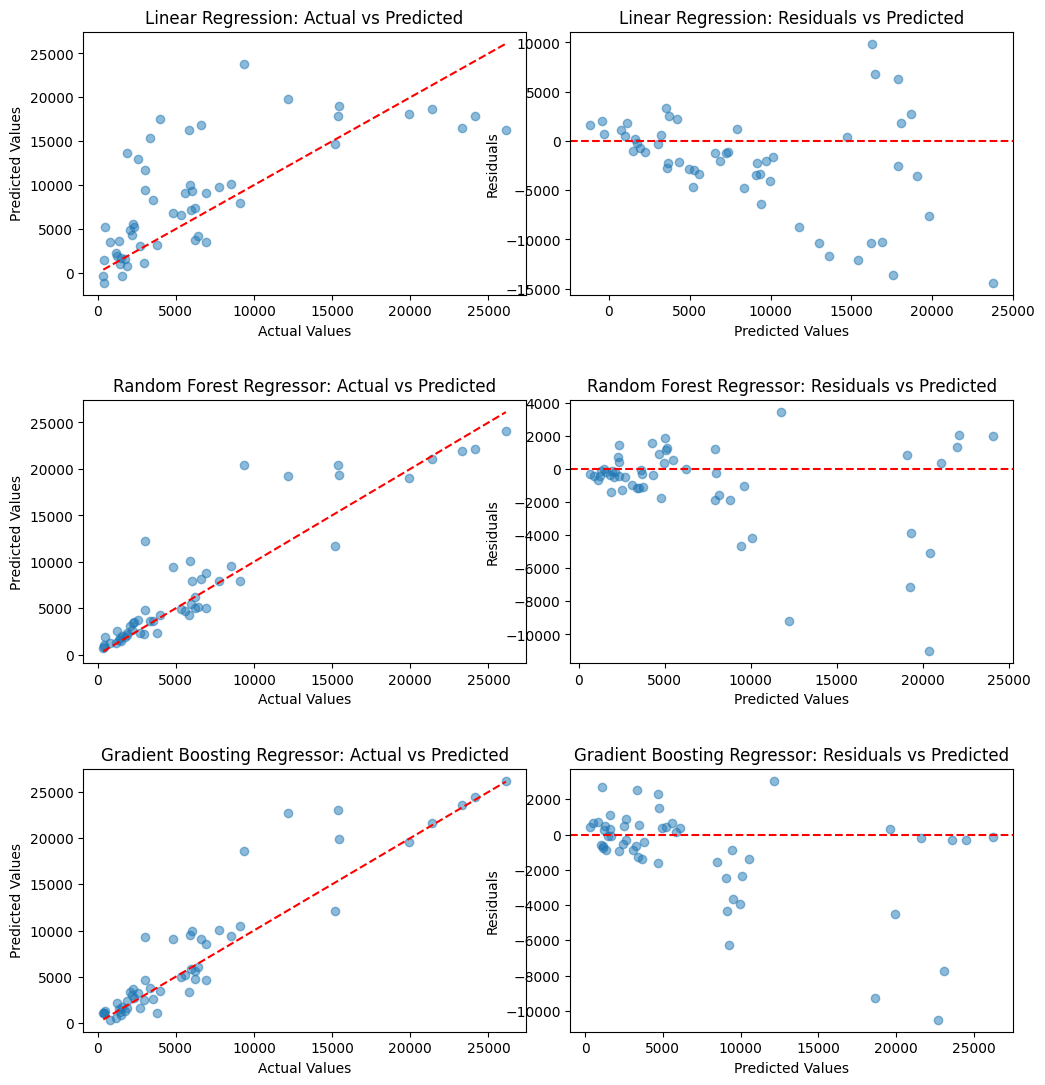

In [7]:
_, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=False)
ax = ax.flatten()

for index, (name, model) in enumerate(best_models_reg.items()):
    model_pipeline = model['pipeline']
    y_pred_reg = model_pipeline.predict(X_test_reg)

    # График фактических значений против предсказанных значений
    ax[index * 2].scatter(y_test_reg, y_pred_reg, alpha=0.5)
    ax[index * 2].plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
    ax[index * 2].set_xlabel('Actual Values')
    ax[index * 2].set_ylabel('Predicted Values')
    ax[index * 2].set_title(f'{name}: Actual vs Predicted')

    # График остатков
    residuals = y_test_reg - y_pred_reg
    ax[index * 2 + 1].scatter(y_pred_reg, residuals, alpha=0.5)
    ax[index * 2 + 1].axhline(y=0, color='red', linestyle='--')
    ax[index * 2 + 1].set_xlabel('Predicted Values')
    ax[index * 2 + 1].set_ylabel('Residuals')
    ax[index * 2 + 1].set_title(f'{name}: Residuals vs Predicted')


plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()